# Mobile Games: A/B Testing

Analyze an A/B test from the popular mobile puzzle game, Cookie Cats.

Reference: [Kaggle](https://www.kaggle.com/code/ekrembayar/a-b-testing-step-by-step-hypothesis-testing/notebook)

# About Dataset

Data source: [Datacamp](https://www.datacamp.com/projects/184)

# Data Preparation

In [241]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from scipy.stats import shapiro
import scipy.stats as stats

False

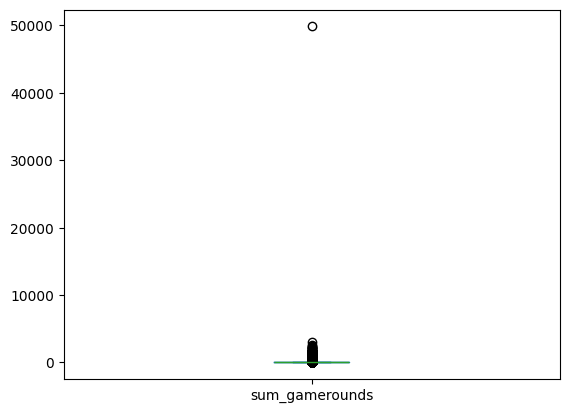

In [242]:
# importing data
df = pd.read_csv("cookie_cats.csv")
df.head()

# data cleaning
df.userid.nunique() == len(df) # check unique value for userid 

df.version.value_counts(normalize=True)

df.sum_gamerounds.plot(kind='box')
df = df[df['sum_gamerounds'] < df.sum_gamerounds.max()] # remove outliers

df.retention_7.value_counts(normalize=True)

# check null values
df.isnull().sum()
df.isnull().values.any()

# Data Understanding: Summary Statistics and Visualization

In [243]:
# summary statistics
display(df.describe()[['sum_gamerounds']].T) # exclude userid sum stats
# df.describe([0.01, 0.05, 0.1, 0.2]).T

# summary statistics by variation
df.groupby('version').agg({'sum_gamerounds':['count', 'mean', 'median', 'std','min', 'max']})

,count,mean,std,min,25%,50%,75%,max
sum_gamerounds,90188.0,51.320253,102.682719,0.0,5.0,16.0,51.0,2961.0


sum_gamerounds                                        
                 count       mean median         std min   max
version                                                       
gate_30          44699  51.342111   17.0  102.057598   0  2961
gate_40          45489  51.298776   16.0  103.294416   0  2640

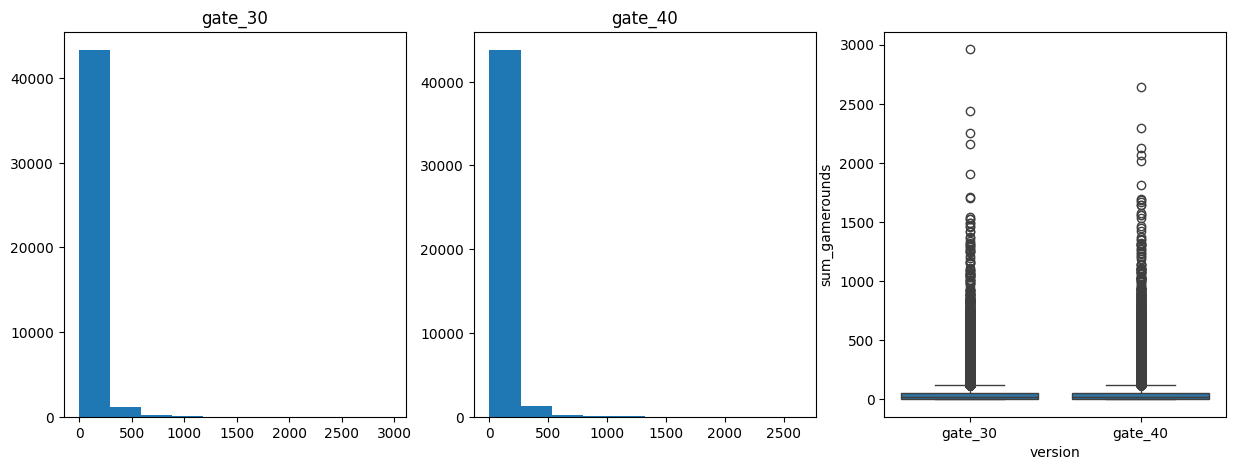

In [244]:
temp = df.groupby('version').agg({'sum_gamerounds':'count'})
# sns.histplot(data=df, x='sum_gamerounds')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(df[df.version == 'gate_30']['sum_gamerounds'])
ax[0].set_title('gate_30')

ax[1].hist(df[df.version == 'gate_40']['sum_gamerounds'])
ax[1].set_title('gate_40')

sns.boxplot(x=df.version, y=df.sum_gamerounds, ax=ax[2])

plt.show()

<Axes: xlabel='index', ylabel='sum_gamerounds'>

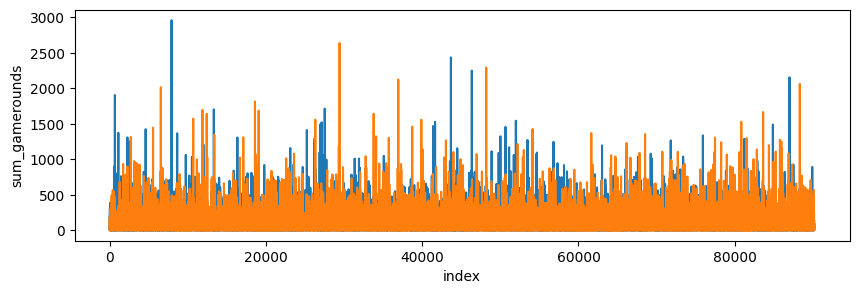

In [245]:
temp = df.reset_index().set_index('index')

fig, ax = plt.subplots(1,1, figsize=(10,3))
sns.lineplot(data=temp[temp.version=='gate_30'], x='index', y='sum_gamerounds')
sns.lineplot(data=temp[temp.version=='gate_40'], x='index', y='sum_gamerounds')

In [246]:
print("Many users just installed the app but never played the game")
df[df.sum_gamerounds==0].groupby('version').size()

Many users just installed the app but never played the game


version
gate_30    1937
gate_40    2057
dtype: int64

Text(0.5, 0, 'Count of users')

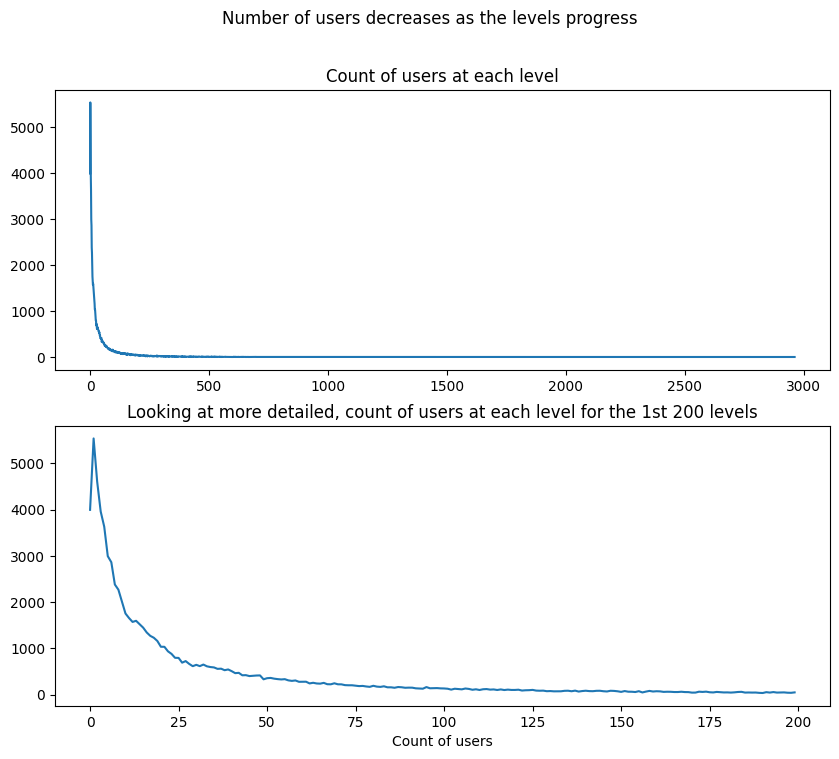

In [247]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
df.groupby('sum_gamerounds').userid.count().plot(ax=ax[0])
df.groupby('sum_gamerounds').userid.count()[:200].plot(ax=ax[1])

plt.suptitle("Number of users decreases as the levels progress")
ax[0].set_title('Count of users at each level')
ax[1].set_title('Looking at more detailed, count of users at each level for the 1st 200 levels')

ax[0].set_xlabel('')
ax[1].set_xlabel('Count of users')

In [248]:
print("Number of users reached gate 30 and gate 40")
df.groupby('sum_gamerounds').userid.count().loc[[30, 40]]

Number of users reached gate 30 and gate 40


sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

In [249]:
print("Investigate whether these two groups are statistically significant")
df.groupby('version').agg({'sum_gamerounds':['count', 'mean', 'median', 'std','min', 'max']})

Investigate whether these two groups are statistically significant


sum_gamerounds                                        
                 count       mean median         std min   max
version                                                       
gate_30          44699  51.342111   17.0  102.057598   0  2961
gate_40          45489  51.298776   16.0  103.294416   0  2640

In [250]:
print("Players' retention - churn rate")
print(pd.DataFrame({'retention_1':df.retention_1.value_counts(normalize=True),
              'retention_7':df.retention_7.value_counts(normalize=True)}))
print(f'{round(df.retention_1.value_counts(normalize=True).loc[False]*100)}% of the players churned 1 day after installing')
print(f'{round(df.retention_7.value_counts(normalize=True).loc[False]*100)}% of the players churned 7 days after installing')


Players' retention - churn rate
       retention_1  retention_7
False     0.554786     0.813944
True      0.445214     0.186056
55% of the players churned 1 day after installing
81% of the players churned 7 days after installing


In [251]:
display(pd.merge(
    pd.pivot(df.groupby('version').retention_1.value_counts(normalize=True).reset_index(),
             index='version',columns='retention_1', values='proportion'),
    pd.pivot(df.groupby('version').retention_7.value_counts(normalize=True).reset_index(), 
             index='version',columns='retention_7', values='proportion'),
    on='version').rename(columns={'False_x':'Churned_1',
                                  'True_x':'Retained_1',
                                  'False_y':'Churned_7',
                                  'True_y':'Churned_7'}
    ))

print("Not much distinction of players' retention was found among these two variations")
print(f'Among {len(df)} users, there are {df[(df.retention_1 == True) & (df.retention_7 == True)].userid.count()} users \
played the game both 1 day and 7 days after installing the game, accounting for {round(df[(df.retention_1 == True) & (df.retention_7 == True)].userid.count() / len(df) * 100)}%')

,Churned_1,Retained_1,Churned_7,Churned_7
version,,,,
gate_30,0.551802,0.448198,0.809817,0.190183
gate_40,0.557717,0.442283,0.818000,0.182000


Not much distinction of players' retention was found among these two variations
Among 90188 users, there are 13182 users played the game both 1 day and 7 days after installing the game, accounting for 15%


In [252]:
df['retention'] = np.where((df.retention_1 == True) & (df.retention_7 == True), True, False)
df.groupby(['version', 'retention'])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version retention                                             
gate_30 False      38023    12.0   28.070273   48.017452  1072
        True        6676   127.0  183.886309  189.626390  2961
gate_40 False      38983    12.0   28.103353   48.927850  2640
        True        6506   133.0  190.282355  194.220077  2294

In [253]:
df.groupby('version').agg({'sum_gamerounds':['count', 'mean', 'median', 'std','min', 'max']})

sum_gamerounds                                        
                 count       mean median         std min   max
version                                                       
gate_30          44699  51.342111   17.0  102.057598   0  2961
gate_40          45489  51.298776   16.0  103.294416   0  2640

# A/B Testing

Assumptions:

- Check normality
- if Normal distribution, check homogenity

Steps:
- Split & Define Control Group & Test Group
- Apply Shapiro Test for normality
- If parametric apply Levene Test for homogeneity of variances
- If Parametric + homogeneity of variances apply T-Test
- If Parametric - homogeneity of variances apply Welch Test
- If Non-parametric apply Mann Whitney U Test directly

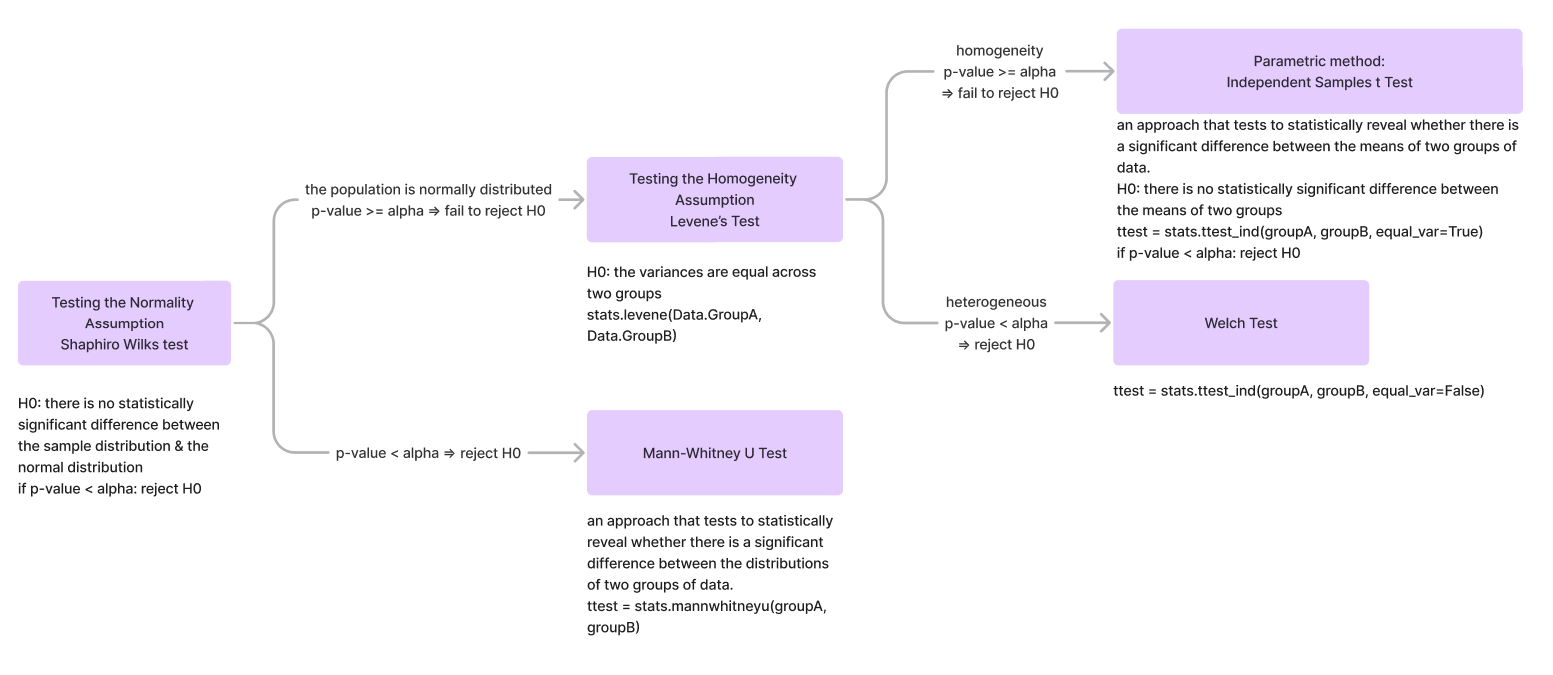
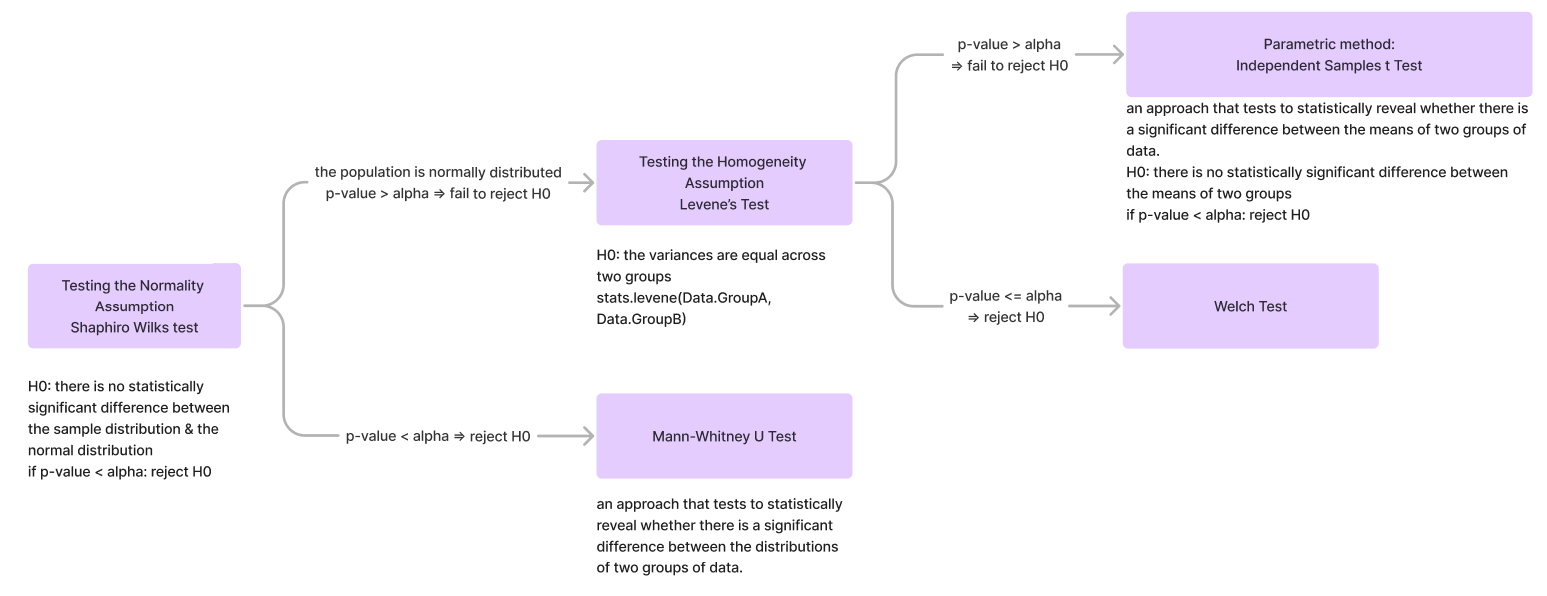
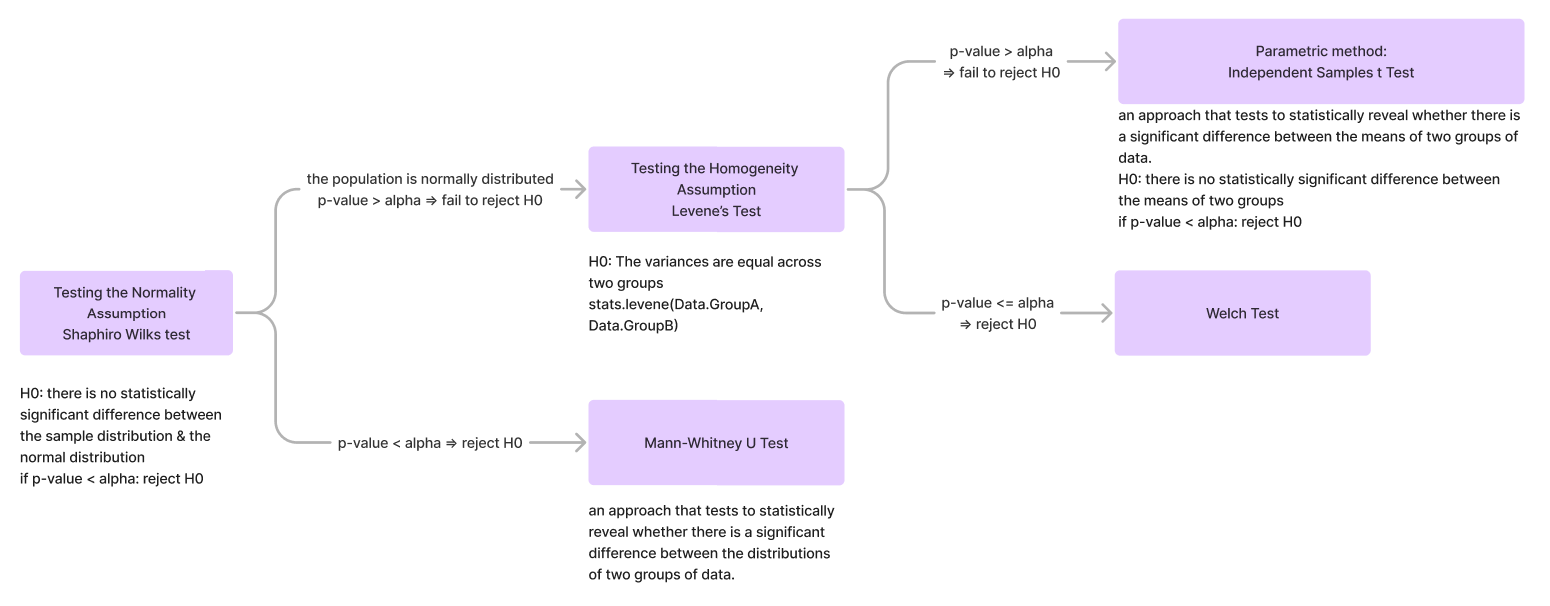

In [254]:
df['version'] = np.where(df.version == 'gate_30', 'A', 'B')
df['retention_combined'] = list(map(lambda x, y: str(x) + "-" + str(y), df.retention_1, df.retention_7))
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7,retention,retention_combined
0,116,A,3,False,False,False,False-False
1,337,A,38,True,False,False,True-False
2,377,B,165,True,False,False,True-False
3,483,B,1,False,False,False,False-False
4,488,B,179,True,True,True,True-True


In [260]:
# split data into 2 groups
groupA = df[df.version == 'A']['sum_gamerounds']
groupB = df[df.version == 'B']['sum_gamerounds']
groupA

0         3
1        38
6         0
11        0
13       39
         ..
90179    14
90180     7
90182    21
90183    10
90186    28
Name: sum_gamerounds, Length: 44699, dtype: int64

Shapiro-Wilk test is a statistical test used to assess whether a given sample of data follows a normal distribution.

- H0: the population is normally distributed.
- alpha level: significant level.
- p-value < alpha => H0 is rejected and the data is not normally distributed.

In [263]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    
    
    
# Apply A/B Testing
AB_Test(dataframe=df, group = "version", target = "sum_gamerounds")

C:\Users\tranthit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.050892,A/B groups are similar!
